# 05 Quantile forecasting using Gradient Boosted Trees

In [1]:
import sys
sys.executable

'/usr/local/bin/python'

## Imports

In [2]:
import re

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import stock_utils.constants as cnst
import stock_utils.data as sd

pd.set_option('display.max_columns', None)

NSE_DATA_DIR = PosixPath('../data/NSE') | Valid: True
SCREENER_EPS_DATA_DIR = PosixPath('../data/Screener.in/EPS') | Valid: True
PROCESSED_DATA_DIR = PosixPath('../data/processed') | Valid: True


## Constants

In [3]:
QUANTILE_LB, QUANTILE_UB = 0.1, 0.9

stock_symbols = sd.get_all_stock_symbols(
    cnst.NSE_DATA_DIR
)

stock_symbols

['DEEPAKFERT', 'HDFCBANK', 'INDIGOPNTS', 'ITBEES', 'JUBLFOOD']

In [4]:
STOCK_SYMBOL = stock_symbols[2]
STOCK_SYMBOL

'INDIGOPNTS'

## Loading stock data

In [5]:
stock_data = sd.StockData(STOCK_SYMBOL)
stock_data

Symbol: INDIGOPNTS
Total records: 775
First record: 2021-02-02
Last record: 2024-03-15

## Modelling

### Target columns

In [6]:
target_cols = stock_data.standardized.filter(regex = "Target.*").columns.to_list()
target_cols

['Target 3D', 'Target 7D', 'Target 15D', 'Target 30D']

In [7]:
pred_input_df = stock_data.standardized.drop(columns = target_cols)
pred_input_df.shape

(775, 43)

In [8]:
stock_data.standardized[target_cols].describe()

,Target 3D,Target 7D,Target 15D,Target 30D
count,772.000000,768.000000,760.000000,745.000000
mean,0.997374,0.994462,0.989138,0.980921
std,0.032186,0.046710,0.067656,0.103178
min,0.844000,0.831000,0.786000,0.741000
25%,0.980000,0.966000,0.946000,0.914000
50%,0.995000,0.990000,0.981000,0.970000
75%,1.011000,1.017000,1.024250,1.029000
max,1.130000,1.206000,1.246000,1.399000


### Data processing

In [9]:
def get_training_data(target_col: str):
    print(f"Target: {target_col}")
    X_df = stock_data.standardized[
        stock_data.standardized[target_col].notnull()
    ].drop(columns = target_cols).copy()
    y = stock_data.standardized[
        stock_data.standardized[target_col].notnull()
    ][target_col].copy()
    print(f"X.shape: {X_df.shape}")
    print(f"y.shape: {y.shape}")

    return X_df, y

### Grid search parameters

In [10]:
param_dict = {
    "n_estimators": [100, 125, 150],
    "learning_rate": [0.05, 0.1, 0.2],
    "max_depth": [2, 3, 4],
    "max_features": ["log2", "sqrt", 0.25],
    "subsample": [0.75, 1.0]
}

feature_importances = pd.DataFrame(
    index = stock_data.standardized.drop(columns = target_cols).columns.to_list()
)

### Model building

In [11]:
def get_model():
    gb_model = GradientBoostingRegressor(
        loss = "squared_error",
        random_state = cnst.RANDOM_STATE
    )

    grid_cv = RandomizedSearchCV(
        gb_model,
        param_dict,
        n_iter = 12,
        cv = 5,
        n_jobs = -1,
        random_state = cnst.RANDOM_STATE
    )

    return grid_cv

def get_quantile_model(quantile: float):
    gb_model = GradientBoostingRegressor(
        loss = "quantile",
        alpha = quantile,
        random_state = cnst.RANDOM_STATE
    )

    grid_cv = RandomizedSearchCV(
        gb_model,
        param_dict,
        n_iter = 12,
        cv = 5,
        n_jobs = -1,
        random_state = cnst.RANDOM_STATE
    )

    return grid_cv

def print_results(y, preds):
    print(f"Target std: {y.std():.3f}")
    print(f"R2: {r2_score(y, preds):.3f}")
    print(f"MSE: {mean_squared_error(y, preds, squared = False):.3f}")
    print(f"MAE: {mean_absolute_error(y, preds):.3f}")

## Training

### `Target 3D`

#### Forecasting model

In [12]:
target_col = target_cols[0]
X, y = get_training_data(target_col)

Target: Target 3D
X.shape: (772, 43)
y.shape: (772,)


In [13]:
model = get_model()
model.fit(X, y)
model.best_params_

{'subsample': 1.0,
 'n_estimators': 125,
 'max_features': 'sqrt',
 'max_depth': 4,
 'learning_rate': 0.05}

In [14]:
pd.DataFrame(model.cv_results_).sort_values('rank_test_score').iloc[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_n_estimators,param_max_features,param_max_depth,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
8,0.348795,0.017929,0.004446,0.000724,1.0,125,sqrt,4,0.05,"{'subsample': 1.0, 'n_estimators': 125, 'max_f...",-0.009970,-0.042737,0.029039,0.023772,-0.171333,-0.034246,0.073247,1
2,0.299378,0.041926,0.005309,0.000878,1.0,100,log2,4,0.05,"{'subsample': 1.0, 'n_estimators': 100, 'max_f...",-0.060903,-0.060295,0.050871,0.031936,-0.137768,-0.035232,0.068886,2
4,0.243001,0.009802,0.005291,0.001941,1.0,125,sqrt,2,0.1,"{'subsample': 1.0, 'n_estimators': 125, 'max_f...",-0.003933,-0.057938,0.035958,-0.014827,-0.178120,-0.043772,0.073528,3
11,0.412742,0.046244,0.006641,0.003976,0.75,150,sqrt,4,0.05,"{'subsample': 0.75, 'n_estimators': 150, 'max_...",-0.012282,-0.080819,0.045811,0.046806,-0.224149,-0.044927,0.101117,4
10,0.307934,0.041710,0.013952,0.002357,0.75,100,sqrt,3,0.05,"{'subsample': 0.75, 'n_estimators': 100, 'max_...",0.011752,-0.021701,0.051496,-0.089530,-0.183104,-0.046217,0.082612,5


In [15]:
feature_importances = feature_importances.join(
    pd.DataFrame(
        model.best_estimator_.feature_importances_,
        index = model.best_estimator_.feature_names_in_,
        columns = [target_col]
    )
)

preds = model.predict(X)
print_results(y, preds)

Target std: 0.032
R2: 0.701
MSE: 0.018
MAE: 0.013


#### Lower quantile model

In [16]:
lb_model = get_quantile_model(QUANTILE_LB)
lb_model.fit(X, y)
lb_model.best_params_

{'subsample': 0.75,
 'n_estimators': 150,
 'max_features': 'log2',
 'max_depth': 4,
 'learning_rate': 0.1}

#### Upper quantile model

In [17]:
ub_model = get_quantile_model(QUANTILE_UB)
ub_model.fit(X, y)
ub_model.best_params_

{'subsample': 0.75,
 'n_estimators': 150,
 'max_features': 'log2',
 'max_depth': 4,
 'learning_rate': 0.1}

#### Predictions

In [18]:
pred_col_name = f'Pred {target_col}'
lb_col_name, ub_col_name = f'LB {target_col}', f'UB {target_col}'

stock_data.processed[pred_col_name] = (model.predict(pred_input_df) * stock_data.processed['Close']).round(2)

stock_data.processed[lb_col_name] = (lb_model.predict(pred_input_df) * stock_data.processed['Close']).round(2)
stock_data.processed[lb_col_name] = stock_data.processed[[lb_col_name, pred_col_name]].min(axis = 1)

stock_data.processed[ub_col_name] = (ub_model.predict(pred_input_df) * stock_data.processed['Close']).round(2)
stock_data.processed[ub_col_name] = stock_data.processed[[ub_col_name, pred_col_name]].max(axis = 1)

stock_data.processed[['Date', 'Close', target_col, pred_col_name, lb_col_name, ub_col_name]].dropna().iloc[-10:, :]

,Date,Close,Target 3D,Pred Target 3D,LB Target 3D,UB Target 3D
762,2024-02-28,1403.40,1408.15,1403.93,1382.73,1421.97
763,2024-02-29,1398.85,1386.35,1391.36,1375.13,1439.32
764,2024-03-01,1400.95,1388.45,1387.99,1372.69,1410.62
765,2024-03-02,1408.15,1374.20,1385.69,1370.64,1427.15
766,2024-03-04,1386.35,1363.55,1372.76,1348.76,1405.09
767,2024-03-05,1388.45,1367.85,1372.63,1350.18,1427.33
768,2024-03-06,1374.20,1337.20,1357.05,1336.33,1390.53
769,2024-03-07,1363.55,1308.65,1342.37,1317.27,1384.07
770,2024-03-11,1367.85,1329.00,1349.21,1333.17,1387.47
771,2024-03-12,1337.20,1341.45,1337.57,1304.65,1359.44


### `Target 7D`

#### Forecasting model

In [19]:
target_col = target_cols[1]
X, y = get_training_data(target_col)

Target: Target 7D
X.shape: (768, 43)
y.shape: (768,)


In [20]:
model = get_model()
model.fit(X, y)
model.best_params_

{'subsample': 0.75,
 'n_estimators': 125,
 'max_features': 'sqrt',
 'max_depth': 3,
 'learning_rate': 0.1}

In [21]:
pd.DataFrame(model.cv_results_).sort_values('rank_test_score').iloc[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_n_estimators,param_max_features,param_max_depth,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.336444,0.100072,0.009347,0.007365,0.75,125,sqrt,3,0.1,"{'subsample': 0.75, 'n_estimators': 125, 'max_...",-0.248727,-0.024648,0.106953,0.007742,-0.494572,-0.130650,0.215975,1
7,0.423160,0.021918,0.004638,0.000829,0.75,125,0.25,3,0.1,"{'subsample': 0.75, 'n_estimators': 125, 'max_...",-0.346387,0.048529,0.104917,-0.079227,-0.391948,-0.132823,0.202503,2
10,0.308681,0.085816,0.006392,0.004657,0.75,100,sqrt,3,0.05,"{'subsample': 0.75, 'n_estimators': 100, 'max_...",-0.269437,-0.018935,0.085729,-0.172314,-0.299204,-0.134832,0.147391,3
4,0.273494,0.015134,0.004228,0.000459,1.0,125,sqrt,2,0.1,"{'subsample': 1.0, 'n_estimators': 125, 'max_f...",-0.163259,-0.077324,0.046331,-0.085229,-0.401529,-0.136202,0.148670,4
6,0.453067,0.137661,0.006134,0.002235,0.75,150,sqrt,3,0.1,"{'subsample': 0.75, 'n_estimators': 150, 'max_...",-0.235746,-0.024759,0.119732,-0.039166,-0.517605,-0.139509,0.220300,5


In [22]:
feature_importances = feature_importances.join(
    pd.DataFrame(
        model.best_estimator_.feature_importances_,
        index = model.best_estimator_.feature_names_in_,
        columns = [target_col]
    )
)

preds = model.predict(X)
print_results(y, preds)

Target std: 0.047
R2: 0.839
MSE: 0.019
MAE: 0.015


#### Lower quantile model

In [23]:
lb_model = get_quantile_model(QUANTILE_LB)
lb_model.fit(X, y)
lb_model.best_params_

{'subsample': 0.75,
 'n_estimators': 150,
 'max_features': 'log2',
 'max_depth': 4,
 'learning_rate': 0.1}

#### Upper quantile model

In [24]:
ub_model = get_quantile_model(QUANTILE_UB)
ub_model.fit(X, y)
ub_model.best_params_

{'subsample': 1.0,
 'n_estimators': 150,
 'max_features': 0.25,
 'max_depth': 4,
 'learning_rate': 0.1}

#### Predictions

In [25]:
pred_col_name = f'Pred {target_col}'
lb_col_name, ub_col_name = f'LB {target_col}', f'UB {target_col}'

stock_data.processed[pred_col_name] = (model.predict(pred_input_df) * stock_data.processed['Close']).round(2)

stock_data.processed[lb_col_name] = (lb_model.predict(pred_input_df) * stock_data.processed['Close']).round(2)
stock_data.processed[lb_col_name] = stock_data.processed[[lb_col_name, pred_col_name]].min(axis = 1)

stock_data.processed[ub_col_name] = (ub_model.predict(pred_input_df) * stock_data.processed['Close']).round(2)
stock_data.processed[ub_col_name] = stock_data.processed[[ub_col_name, pred_col_name]].max(axis = 1)

stock_data.processed[['Date', 'Close', target_col, pred_col_name, lb_col_name, ub_col_name]].dropna().iloc[-10:, :]

,Date,Close,Target 7D,Pred Target 7D,LB Target 7D,UB Target 7D
758,2024-02-22,1451.05,1408.15,1423.59,1404.61,1485.11
759,2024-02-23,1443.50,1386.35,1436.16,1389.90,1490.79
760,2024-02-26,1427.80,1388.45,1410.67,1386.91,1464.81
761,2024-02-27,1423.40,1374.20,1394.16,1373.39,1457.07
762,2024-02-28,1403.40,1363.55,1377.93,1360.34,1437.37
763,2024-02-29,1398.85,1367.85,1380.51,1349.50,1435.96
764,2024-03-01,1400.95,1337.20,1343.11,1334.67,1428.05
765,2024-03-02,1408.15,1308.65,1342.82,1307.94,1386.24
766,2024-03-04,1386.35,1329.00,1368.98,1330.26,1418.18
767,2024-03-05,1388.45,1341.45,1371.51,1340.30,1431.56


### `Target 15D`

#### Forecasting model

In [26]:
target_col = target_cols[2]
X, y = get_training_data(target_col)

Target: Target 15D
X.shape: (760, 43)
y.shape: (760,)


In [27]:
model = get_model()
model.fit(X, y)
model.best_params_

{'subsample': 0.75,
 'n_estimators': 150,
 'max_features': 'log2',
 'max_depth': 4,
 'learning_rate': 0.1}

In [28]:
pd.DataFrame(model.cv_results_).sort_values('rank_test_score').iloc[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_n_estimators,param_max_features,param_max_depth,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.477408,0.121805,0.008011,0.004223,0.75,150,log2,4,0.1,"{'subsample': 0.75, 'n_estimators': 150, 'max_...",0.044220,-0.175403,0.355179,0.236860,-0.335984,0.024974,0.254850,1
2,0.371025,0.083052,0.005585,0.000801,1.0,100,log2,4,0.05,"{'subsample': 1.0, 'n_estimators': 100, 'max_f...",-0.154949,-0.161213,0.232247,0.228261,-0.175525,-0.006236,0.193212,2
10,0.250965,0.036914,0.004668,0.000603,0.75,100,sqrt,3,0.05,"{'subsample': 0.75, 'n_estimators': 100, 'max_...",-0.310231,-0.167193,0.243149,0.171030,-0.064425,-0.025534,0.206621,3
5,0.721178,0.148625,0.006097,0.001593,1.0,150,0.25,4,0.1,"{'subsample': 1.0, 'n_estimators': 150, 'max_f...",-0.468058,-0.049315,0.338932,0.295773,-0.264651,-0.029463,0.312911,4
8,0.347154,0.016642,0.004232,0.000431,1.0,125,sqrt,4,0.05,"{'subsample': 1.0, 'n_estimators': 125, 'max_f...",-0.032246,-0.185263,0.359418,0.118570,-0.412625,-0.030429,0.262386,5


In [29]:
feature_importances = feature_importances.join(
    pd.DataFrame(
        model.best_estimator_.feature_importances_,
        index = model.best_estimator_.feature_names_in_,
        columns = [target_col]
    )
)

preds = model.predict(X)
print_results(y, preds)

Target std: 0.068
R2: 0.976
MSE: 0.010
MAE: 0.008


#### Lower quantile model

In [30]:
lb_model = get_quantile_model(QUANTILE_LB)
lb_model.fit(X, y)
lb_model.best_params_

{'subsample': 1.0,
 'n_estimators': 150,
 'max_features': 'log2',
 'max_depth': 4,
 'learning_rate': 0.1}

#### Upper quantile model

In [31]:
ub_model = get_quantile_model(QUANTILE_UB)
ub_model.fit(X, y)
ub_model.best_params_

{'subsample': 0.75,
 'n_estimators': 150,
 'max_features': 'log2',
 'max_depth': 4,
 'learning_rate': 0.1}

#### Predictions

In [32]:
pred_col_name = f'Pred {target_col}'
lb_col_name, ub_col_name = f'LB {target_col}', f'UB {target_col}'

stock_data.processed[pred_col_name] = (model.predict(pred_input_df) * stock_data.processed['Close']).round(2)

stock_data.processed[lb_col_name] = (lb_model.predict(pred_input_df) * stock_data.processed['Close']).round(2)
stock_data.processed[lb_col_name] = stock_data.processed[[lb_col_name, pred_col_name]].min(axis = 1)

stock_data.processed[ub_col_name] = (ub_model.predict(pred_input_df) * stock_data.processed['Close']).round(2)
stock_data.processed[ub_col_name] = stock_data.processed[[ub_col_name, pred_col_name]].max(axis = 1)

stock_data.processed[['Date', 'Close', target_col, pred_col_name, lb_col_name, ub_col_name]].dropna().iloc[-10:, :]

,Date,Close,Target 15D,Pred Target 15D,LB Target 15D,UB Target 15D
750,2024-02-12,1449.40,1408.15,1410.01,1363.10,1482.52
751,2024-02-13,1474.40,1386.35,1385.94,1380.22,1481.78
752,2024-02-14,1458.40,1388.45,1394.14,1372.77,1467.45
753,2024-02-15,1499.60,1374.20,1379.34,1372.19,1459.76
754,2024-02-16,1494.70,1363.55,1362.58,1362.58,1469.13
755,2024-02-19,1511.80,1367.85,1376.11,1356.19,1490.10
756,2024-02-20,1503.50,1337.20,1361.15,1337.84,1485.98
757,2024-02-21,1492.05,1308.65,1349.85,1338.56,1459.07
758,2024-02-22,1451.05,1329.00,1362.23,1333.27,1467.30
759,2024-02-23,1443.50,1341.45,1372.03,1339.24,1472.18


### `Target 30D`

#### Forecasting model

In [33]:
target_col = target_cols[3]
X, y = get_training_data(target_col)

Target: Target 30D
X.shape: (745, 43)
y.shape: (745,)


In [34]:
model = get_model()
model.fit(X, y)
model.best_params_

{'subsample': 1.0,
 'n_estimators': 125,
 'max_features': 'sqrt',
 'max_depth': 4,
 'learning_rate': 0.05}

In [35]:
pd.DataFrame(model.cv_results_).sort_values('rank_test_score').iloc[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_n_estimators,param_max_features,param_max_depth,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
8,0.528758,0.086168,0.006689,0.003597,1.0,125,sqrt,4,0.05,"{'subsample': 1.0, 'n_estimators': 125, 'max_f...",-0.361958,-0.450389,0.131059,0.095784,-0.350373,-0.187176,0.248114,1
10,0.259266,0.029989,0.004026,0.000278,0.75,100,sqrt,3,0.05,"{'subsample': 0.75, 'n_estimators': 100, 'max_...",-0.407590,-0.253401,0.068336,0.121610,-0.503129,-0.194835,0.250254,2
11,0.374484,0.020821,0.003415,0.000838,0.75,150,sqrt,4,0.05,"{'subsample': 0.75, 'n_estimators': 150, 'max_...",-0.416955,-0.360183,0.098643,0.121780,-0.538930,-0.219129,0.275137,3
7,0.486841,0.077178,0.006445,0.003854,0.75,125,0.25,3,0.1,"{'subsample': 0.75, 'n_estimators': 125, 'max_...",-0.558765,-0.350998,0.258909,0.095719,-0.644770,-0.239981,0.357600,4
9,0.584572,0.120166,0.004655,0.001244,1.0,150,log2,4,0.1,"{'subsample': 1.0, 'n_estimators': 150, 'max_f...",-0.147683,-0.630228,-0.044034,0.072625,-0.663761,-0.282616,0.305755,5


In [36]:
feature_importances = feature_importances.join(
    pd.DataFrame(
        model.best_estimator_.feature_importances_,
        index = model.best_estimator_.feature_names_in_,
        columns = [target_col]
    )
)

preds = model.predict(X)
print_results(y, preds)

Target std: 0.103
R2: 0.965
MSE: 0.019
MAE: 0.015


#### Lower quantile model

In [37]:
lb_model = get_quantile_model(QUANTILE_LB)
lb_model.fit(X, y)
lb_model.best_params_

{'subsample': 1.0,
 'n_estimators': 150,
 'max_features': 0.25,
 'max_depth': 4,
 'learning_rate': 0.1}

#### Upper quantile model

In [38]:
ub_model = get_quantile_model(QUANTILE_UB)
ub_model.fit(X, y)
ub_model.best_params_

{'subsample': 1.0,
 'n_estimators': 150,
 'max_features': 0.25,
 'max_depth': 4,
 'learning_rate': 0.1}

#### Predictions

In [39]:
pred_col_name = f'Pred {target_col}'
lb_col_name, ub_col_name = f'LB {target_col}', f'UB {target_col}'

stock_data.processed[pred_col_name] = (model.predict(pred_input_df) * stock_data.processed['Close']).round(2)

stock_data.processed[lb_col_name] = (lb_model.predict(pred_input_df) * stock_data.processed['Close']).round(2)
stock_data.processed[lb_col_name] = stock_data.processed[[lb_col_name, pred_col_name]].min(axis = 1)

stock_data.processed[ub_col_name] = (ub_model.predict(pred_input_df) * stock_data.processed['Close']).round(2)
stock_data.processed[ub_col_name] = stock_data.processed[[ub_col_name, pred_col_name]].max(axis = 1)

stock_data.processed[['Date', 'Close', target_col, pred_col_name, lb_col_name, ub_col_name]].dropna().iloc[-10:, :]

,Date,Close,Target 30D,Pred Target 30D,LB Target 30D,UB Target 30D
735,2024-01-19,1469.25,1408.15,1400.55,1394.31,1443.48
736,2024-01-20,1460.50,1386.35,1375.81,1375.81,1407.71
737,2024-01-23,1416.00,1388.45,1376.77,1341.51,1403.17
738,2024-01-24,1431.10,1374.20,1373.38,1353.27,1411.12
739,2024-01-25,1450.00,1363.55,1361.70,1357.45,1410.35
740,2024-01-29,1465.40,1367.85,1392.42,1366.35,1427.14
741,2024-01-30,1448.15,1337.20,1351.40,1336.56,1412.11
742,2024-01-31,1443.45,1308.65,1341.56,1309.70,1391.64
743,2024-02-01,1421.60,1329.00,1354.75,1335.95,1402.52
744,2024-02-02,1418.90,1341.45,1355.33,1340.66,1401.70


## Feature importances

In [40]:
feature_importances['Mean'] = feature_importances.mean(axis = 1)
(feature_importances.sort_values('Mean', ascending = False) * 100).round(1)

,Target 3D,Target 7D,Target 15D,Target 30D,Mean
PE,8.4,14.2,13.8,24.0,15.1
DayOfYear,6.1,11.5,14.7,12.4,11.2
52W H,5.5,11.0,6.3,6.1,7.2
Month,2.3,3.0,3.0,12.8,5.3
Range 60MA,3.9,3.7,4.6,6.6,4.7
52W L,1.9,2.6,7.6,4.4,4.1
Close 30MA,3.2,4.2,4.8,2.6,3.7
Range 15MA,6.7,1.7,3.8,2.1,3.6
Close 60MA,3.4,4.6,2.4,2.7,3.3
VWAP 60MA,3.9,3.0,4.1,2.0,3.2


## Forecasts

In [41]:
stock_data.processed.filter(regex = "(Date)|(Close$)|(Pred.*)").iloc[-10:, :]

,Date,Close,Pred Target 3D,Pred Target 7D,Pred Target 15D,Pred Target 30D
765,2024-03-02,1408.15,1385.69,1342.82,1365.74,1407.41
766,2024-03-04,1386.35,1372.76,1368.98,1389.30,1439.01
767,2024-03-05,1388.45,1372.63,1371.51,1388.09,1482.61
768,2024-03-06,1374.20,1357.05,1374.09,1410.38,1465.00
769,2024-03-07,1363.55,1342.37,1375.30,1417.34,1477.26
770,2024-03-11,1367.85,1349.21,1376.60,1407.46,1468.19
771,2024-03-12,1337.20,1337.57,1370.08,1414.07,1440.87
772,2024-03-13,1308.65,1311.02,1346.63,1393.54,1453.22
773,2024-03-14,1329.00,1323.37,1334.66,1392.84,1457.36
774,2024-03-15,1341.45,1345.18,1356.55,1435.06,1463.02


Date: 2024-03-15
Close: 1341.45
Target 3D: 1345.18 (1316.28 to 1394.26)
Target 7D: 1356.55 (1293.98 to 1425.49)
Target 15D: 1435.06 (1351.99 to 1458.36)
Target 30D: 1463.02 (1344.01 to 1463.04)


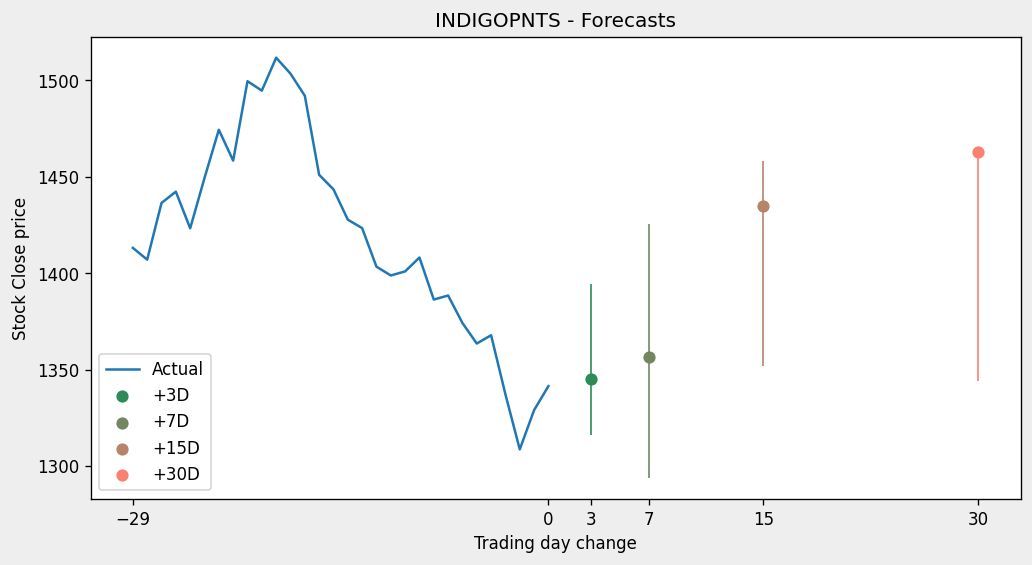

In [42]:
plt.figure(figsize = (10, 5), dpi = 120, facecolor = "#eee")

plt.plot(
    range(-29, 1), 
    stock_data.processed['Close'].iloc[-30:], 
    label = "Actual"
)

latest_preds = stock_data.processed.iloc[-1]
print(f"Date: {latest_preds['Date'].date()}")
print(f"Close: {latest_preds['Close']}")

color_palette = sns.color_palette("blend:seagreen,salmon", n_colors = len(target_cols))
xticks = [-29, 0]

for i, target_col in enumerate(target_cols):
    print(f"{target_col}: {latest_preds[f'Pred {target_col}']}", end = " ")
    print(f"({latest_preds[f'LB {target_col}']} to {latest_preds[f'UB {target_col}']})")
    
    target_day = int(re.search("\d+", target_col)[0])
    xticks.append(target_day)

    plt.scatter(
        target_day, 
        latest_preds[f'Pred {target_col}'],
        color = color_palette[i],
        s = 40,
        label = f"+{target_day}D"
    )
    plt.vlines(
        x = target_day,
        ymin = latest_preds[f'LB {target_col}'],
        ymax = latest_preds[f'UB {target_col}'],
        linewidth = 1,
        colors = color_palette[i]
    )

plt.xlabel("Trading day change")
plt.ylabel("Stock Close price")
plt.title(f"{STOCK_SYMBOL} - Forecasts")
plt.xticks(xticks)
plt.legend()
plt.show()